## Train a rate network to generate sines at different frequencies in response to a static input.
    - Use FORCE to train a brian network to generate the latents, then use reward-based learning to change network behavior.

In [8]:
# import stuff
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.fft import fft,fftfreq
import datetime
import scipy
import pickle

In [4]:
# define a simple network composed of recurrent J weights and a single linear readout
class multiSpeedRNN(nn.Module):
    def __init__(self, nneurons: int = 200, save_path: str = None, lr: float =1e-3,
                 device: torch.device = None, dt: float=0.01, tau: float = 0.1):
        super().__init__()

        # will almost always want to use the CPU to train
        if device is None:
            self.device = torch.device('cpu')
            device = self.device
        else:
            self.device = device

        # initialize all of our weights and set a few parameters
        J_mat = (1.2 * np.random.randn(nneurons, nneurons)/np.sqrt(nneurons))
        self.J = nn.Parameter(torch.from_numpy(J_mat.astype(np.float32)).to(device))
        self.Wout = nn.Parameter(torch.from_numpy((np.random.randn(1, nneurons)/np.sqrt(nneurons)).astype(np.float32)).to(device))
        self.Win  = nn.Parameter(torch.from_numpy((np.random.randn(nneurons,1)/np.sqrt(nneurons)).astype(np.float32)).to(device))
        self.neural_nonlinearity = nn.Tanh()
        self.dt = dt
        self.tau = tau
        self.opt = torch.optim.Adam(self.parameters(), lr=lr)
        self.save_path = save_path
        self.total_time_range = [5,8]
        self.input_on_time_range = [1,3]
        self.output_delay = tau * 2
        self.Loss = []
        self.create_targets_and_inputs()
        self.output = None
        self.batch_size = 4
        self.initialState = torch.randn((self.J.shape[0], self.batch_size), device=device) / np.sqrt(self.J.shape[0])

    def create_targets_and_inputs(self, frequencies=None, amplitude: int = 1):

        if frequencies is None:
            frequencies = [1, 2, 3, 4]

        # choose a random duration for this trial
        trial_time = np.diff(self.total_time_range)[0] * np.random.random() + self.total_time_range[0]

        # duration of trial (in samples)
        trl_l = int(trial_time / self.dt)

        # choose a random time for the input to go high (start movement)
        start_idx = np.random.randint(low=int(self.input_on_time_range[0]/self.dt),high=int(self.input_on_time_range[1]/self.dt))

        # index where the output starts
        movement_start_idx = start_idx + int(self.output_delay / self.dt) - 1

        # movement duration (in sec)
        move_duration = (trl_l - movement_start_idx) * self.dt

        # time vector (will be useful for creating targets)
        movement_times = np.arange(0,move_duration,self.dt)

        # define our input vectors
        inputs = np.zeros((trl_l,len(frequencies))) + (np.arange(len(frequencies))+1)

        # make the inputs turn on at startIdx
        inputs[:start_idx,:] = 0

        # define our outputs
        targets = np.zeros((trl_l,len(frequencies)))
        for ii in range(len(frequencies)):
            targets[movement_start_idx:,ii] = amplitude * np.sin(movement_times * (frequencies[ii] * 2 * np.pi))

        self.Targets = targets
        self.Inputs  = inputs

    def forward(self, targets: np.ndarray = None, inputs: np.ndarray = None, trial_length: int = None, noise_scale: float = 1e-5):
        device = self.device
        batch_size = 4
        Targets = torch.from_numpy(targets.astype(np.float32))
        Inputs = torch.from_numpy(inputs.astype(np.float32))
        position_store = torch.zeros(int(trial_length), batch_size)

        # cycle through trials
        for trl in range(batch_size):

            xm1 = self.initialState
            rm1 = self.neural_nonlinearity(xm1)

            for idx in np.arange(0,trial_length):
                xm1 = xm1 + self.dt/self.tau * (-xm1 + (self.J @ rm1 + (Inputs[idx,trl] * self.Win) +
                                            torch.randn(rm1.shape, device=device) * np.sqrt(noise_scale)))
                rm1 = self.neural_nonlinearity(xm1)
                position_store[idx,trl] = (self.Wout @ rm1)[0][0]

        # average loss over time and trials
        loss = ((Targets - position_store)**2).mean(axis=0).mean()

        self.output = position_store
        return loss


    def fit_initial_m1(self, trials: int = 2000):
        m1_params = [self.J, self.Wout, self.Win]
        optimizer = torch.optim.Adam(m1_params, lr=1e-3)
        for trial in range(trials):
            optimizer.zero_grad()
            targets = self.Targets
            inputs  = self.Inputs
            loss = self.forward(targets = targets,inputs = inputs,trial_length = targets.shape[0])
            self.Loss.append(loss.item())
            loss.backward()
            optimizer.step()

    # return inputs, rates, targets, outputs, without any noise
    def returnRates(self,trial_time: float=8.0,input_on_time: float=2):

        # generate our inputs
        frequencies = [1, 2, 3, 4]

        # duration of trial (in samples)
        trl_l = int(trial_time / self.dt)

        # choose a random time for the input to go high (start movement)
        start_idx = int(input_on_time/self.dt)

        # index where the output starts
        movement_start_idx = start_idx + int(self.output_delay / self.dt) - 1

        # movement duration (in sec)
        move_duration = (trl_l - movement_start_idx) * self.dt

        # time vector (will be useful for creating targets)
        movement_times = np.arange(0,move_duration,self.dt)

        # define our input vectors
        inputs = np.zeros((trl_l,len(frequencies))) + (np.arange(len(frequencies))+1)

        # make the inputs turn on at startIdx
        inputs[:start_idx,:] = 0

        # convert to a tensor
        Inputs = torch.from_numpy(inputs.astype(np.float32))

        # define our outputs
        targets = np.zeros((trl_l,len(frequencies)))
        amplitude=1
        for ii in range(len(frequencies)):
            targets[movement_start_idx:,ii] = amplitude * np.sin(movement_times * (frequencies[ii] * 2 * np.pi))


        # run the model forward
        numNeurons = self.initialState.shape[0]

        # rates are T x N x C
        rates = np.zeros((trl_l,numNeurons,4))

        # output is T x C
        output = np.zeros((trl_l,4))

        # cycle through conditions
        for trl in range(4):

            xm1 = self.initialState
            rm1 = self.neural_nonlinearity(xm1)

            for idx in np.arange(0,trl_l):
                xm1 = xm1 + self.dt/self.tau * (-xm1 + (self.J @ rm1 + (Inputs[idx,trl] * self.Win)))
                rm1 = self.neural_nonlinearity(xm1)
                rates[idx,:,trl] = rm1.detach().numpy()[:,0]
                output[idx,trl]  = (self.Wout @ rm1).detach().numpy()[0][0]


        return inputs, targets, output, rates






### Train the model with backprop

In [5]:
# initialize and fit the model
model = multiSpeedRNN()
model.fit_initial_m1()

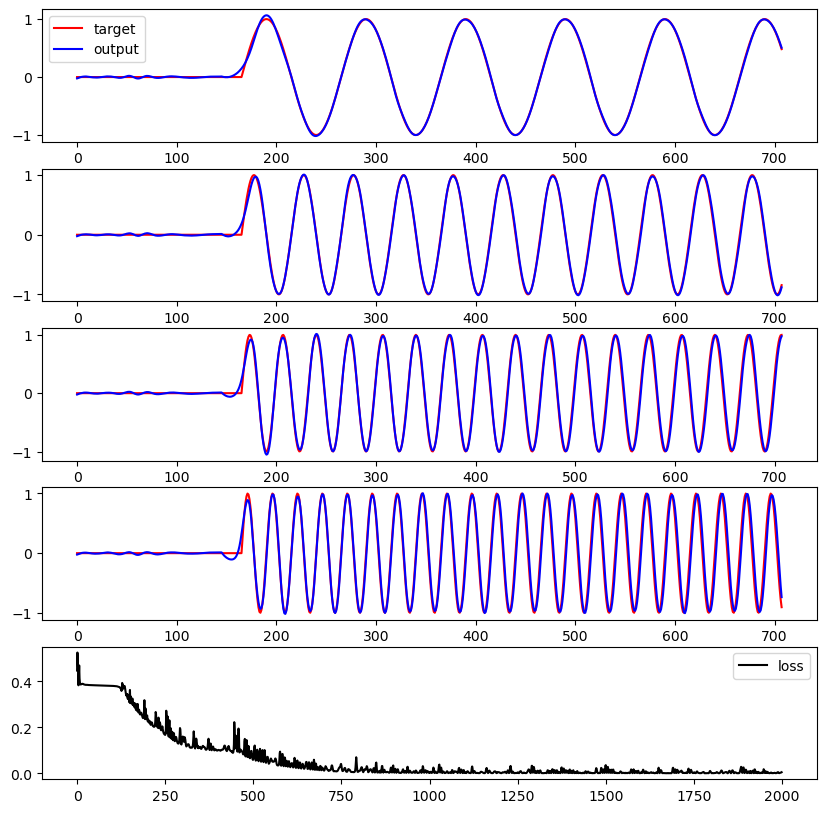

In [6]:
# plot the final output and the loss over training
modelOutput = model.output.detach().numpy()
target = model.Targets
loss = model.Loss
plt.figure(figsize=(10,10))
for ii in range(4):

    plt.subplot(5,1,ii+1);
    plt.plot(target[:,ii],'r',label = 'target');
    plt.plot(modelOutput[:,ii],'b',label='output');
    if ii == 0:
        plt.legend();

plt.subplot(5,1,5);
plt.plot(loss,'k',label='loss');
plt.legend();


In [12]:
# save the model
savePath = '/Users/andrew/Documents/GitHub/basal_ganglia/networks/trainedModels/multiSpeedCycling/'

# get current time
ct = str(datetime.datetime.now())[:19]

# replace colons with an underscore
ct = ct.replace(':','_')

# set up the path and dictionary
savePath = savePath
state_dict = model.state_dict()
data_dict = {'model_state': state_dict, 'full_model': model}

# save
np.save(savePath + ct + '.npy',data_dict)

In [226]:
# return the rates (and inputs, targets, and outputs)
# rates are T x N x C
inputs, targets, output, rates = model.returnRates()

# pull out some useful numbers
trialDur, numN, numC = rates.shape


four dimensions explain 0.8622933059723092 percent of total variance
ten dimensions explain 0.9574895247700872 percent of total variance


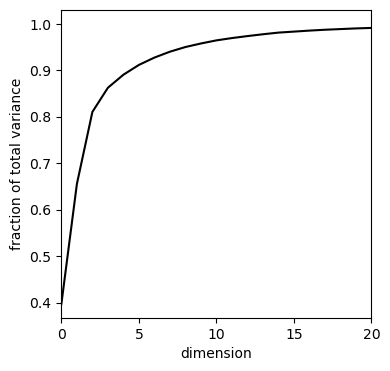

In [100]:
# run pca on the rates and extract the top K factors

# turn rates into a CT x N matrix
rates_rs = rates.transpose(0,2,1).reshape(-1,numN,order='F')

pca = PCA(n_components=numN)
proj = pca.fit_transform(rates_rs)

# generate a scree plot
varExp = pca.explained_variance_ratio_
plt.figure(figsize=(4,4))
plt.plot(np.cumsum(varExp),'k')
plt.ylabel('fraction of total variance');
plt.xlabel('dimension');
plt.xlim([0,20]);

# print some useful values
print('four dimensions explain ' + str(np.sum(varExp[:4])) + ' percent of total variance');
print('ten dimensions explain ' + str(np.sum(varExp[:10])) + ' percent of total variance');

### Train a second model to generate Z

In [897]:
### Train W weights using RLS ###
# fix W_in (taken from the rate model above), choose U randomly

## define a few parameters ##

# network time constant (in msec)
tau = 10

# gain for U weights
g_U = 0.1

# U weights are drawn from a uniform distribution. Set range of this distribution
uMin = -1
uMax = 1

# gain for the input weights
g_W_in = 0.1


# gain for J0 weights. We want these to be fairly small.
g_j0 = 0.5

# gain for initial W weights
g_w  = 0.025

# initial learning rate
alpha = 1

# number of latents
numZ = 20

## draw our U and J0 weights ##

# U first
U = np.random.uniform(low=uMin,high=uMax, size=(numZ,numN)) * g_U

# J0
J0 = np.random.normal(loc=0, scale=(g_j0**2)/(numN * tau**2), size=(numN,numN))

# W_in
#W_in = model.Win.detach().numpy()
W_in = np.random.uniform(low=uMin,high=uMax, size=(numN,1)) * g_W_in

## define our target latents, Z ##
Z_target = proj[:,:numZ]

# reshape to be T x C x K
Z_target_rs = Z_target.reshape(-1,numC,numZ,order='F').transpose(0,2,1)


## rename our inputs ##
INPUT = np.copy(inputs)

## number of trials to train ##
numTrials = 50

## trial duration ##
trlDur = rates.shape[0]

## initialize W ##
W = np.random.normal(loc=0,scale=1/(numN * g_w),size=(numN,numZ))

## initial state, x0 ##
x0 = np.random.normal(loc=0, scale=1,size=(numN,1)) / np.sqrt(numN)

## initial rate, r0 ##
r0 = np.zeros((numN,1))

## initial latents, z0 ##
z0 = np.zeros((numZ,1))

## initial value of P ##
P = np.eye(numN) / alpha

## scale of the training noise ##
noiseScale = 1e-6


In [898]:
# cycle through trials

# initialize an array to hold output
networkOutput = np.zeros((trlDur,numZ,numC,numTrials))

for trl in range(numTrials):

    # cycle through conditions
    for cc in range(numC):

        # set the initial state, rate, and latent
        x = np.copy(x0)
        r = np.copy(r0)
        z = np.copy(z0)

        # cycle through the trial
        for ii in range(trlDur):

            # update our state
            x += (1/tau) * (-x + (J0.T@r) + (U.T@z) + (INPUT[ii,cc] * W_in)
                            + np.random.normal(loc = 0, scale = np.sqrt(noiseScale), size = x.shape))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = W.T@r

            # save the output
            networkOutput[ii,:,cc,trl] = z[:,0]

            # calculate the error
            error = np.atleast_2d(z[:,0] - Z_target_rs[ii,:,cc])

            # update the weights
            W = W - ((P @ r)@error)

            # update P
            P = P - ((P @ r @ r.T @ P)/(1 + (r.T @ P @ r)))


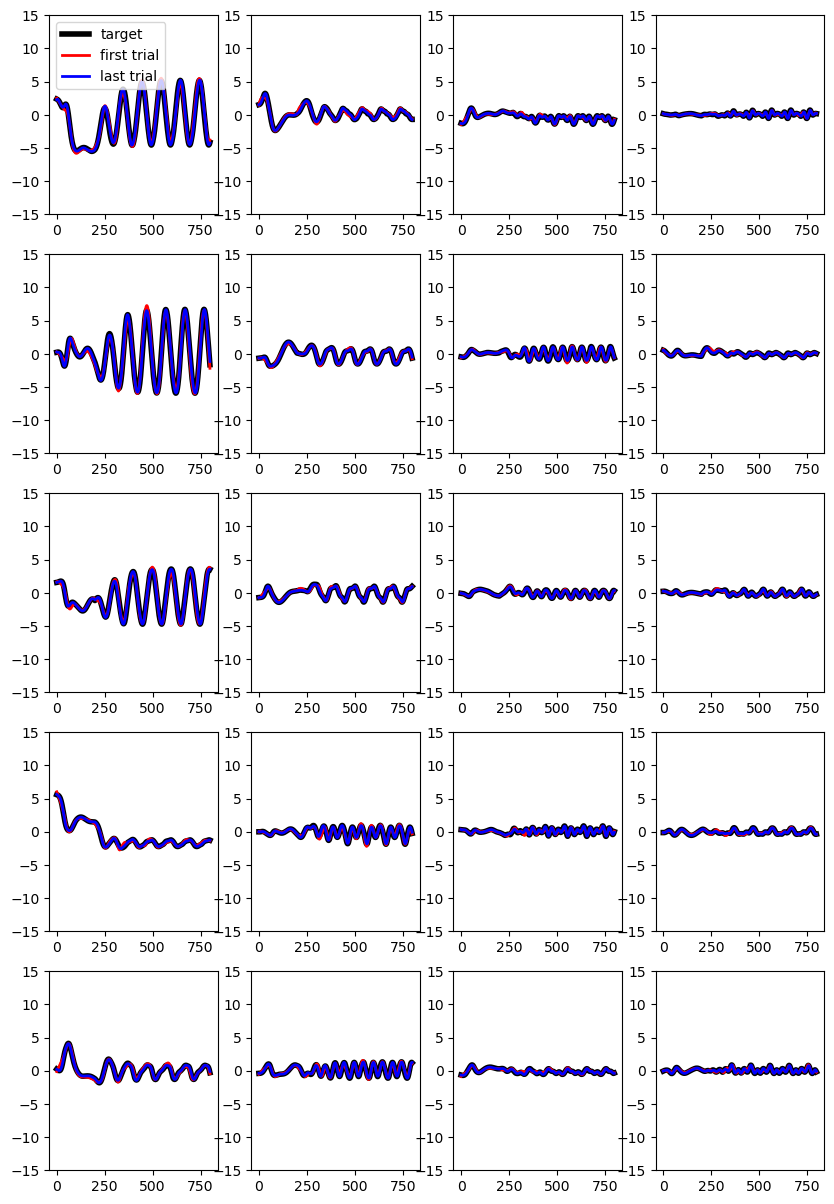

In [900]:
# plot the first and last trial (along with the target)
numRows = 5
fig, ax = plt.subplots(numRows,4, figsize = (10,15))

# only plot 1 condition
cond = 1

for ii in range(numZ):

    # get the row and column index
    rIdx = np.mod(ii,numRows)
    cIdx = (ii//numRows)

    # plot the target
    ax[rIdx,cIdx].plot(Z_target_rs[:,ii,cond],'k',linewidth=4,label='target');

    # plot the first trial
    ax[rIdx,cIdx].plot(networkOutput[:,ii,cond,0],'r',linewidth=2,label='first trial')

    # plot the last trial
    ax[rIdx,cIdx].plot(networkOutput[:,ii,cond,-1],'b',linewidth=2,label='last trial')

    # change the y scale
    ax[rIdx,cIdx].set_ylim([-15,15]);


    if ii==0:
        ax[rIdx,cIdx].legend()


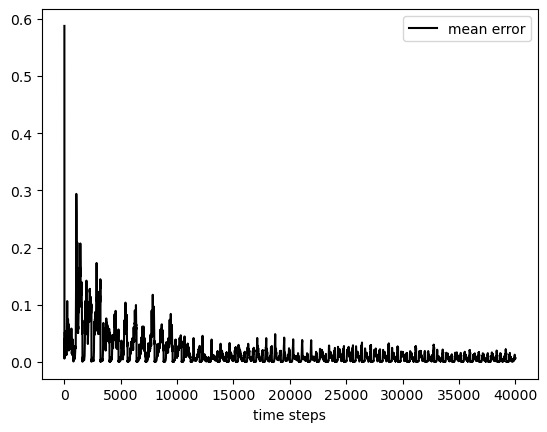

In [901]:
# plot error (averaged over output dimensions) as a function of training steps
meanError = ((networkOutput - np.tile(Z_target_rs[:,:,:,np.newaxis], (1,1,1,numTrials)))**2).mean(axis=1).squeeze().mean(axis=1).squeeze()

# reshape to be size (T x Trl) x 1
meanError_rs = np.reshape(meanError,(-1,1),order='F')

# plot
plt.plot(meanError_rs[:,0],'k',label='mean error');
plt.legend();
plt.xlabel('time steps');
# plt.ylabel('error');

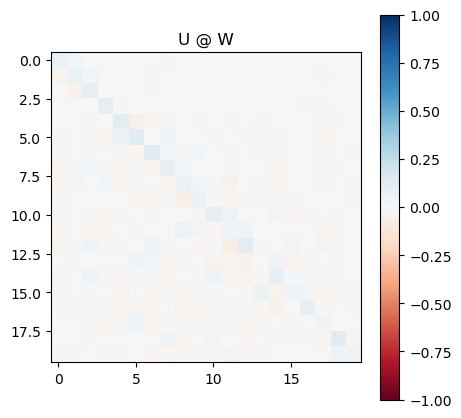

In [902]:
##  how orthogonal are U and W? ##

# normalize columns of W and (rows of) U to unity
W_norm = W / np.linalg.norm(W,axis=0)
U_norm = (U.T / np.linalg.norm(U.T,axis=0)).T

# calculate product of U and W
plt.figure(figsize=(5,5))
plt.imshow(U_norm@W_norm,cmap='RdBu',vmin=-1,vmax=1);plt.colorbar();
plt.title('U @ W');


### Plug in a B
    - B will allow us to readout the target (for the rate network) from the activity of the units
    - B will be orthogonal-ish to W

In [903]:
# function for getting the rates from the trained network
def returnRates(u,ipt,b=None):

    ## initialize arrays to track rates and (if we are given a b) output of the network ##

    # useful numbers
    trlDuration, numConds = ipt.shape
    numLatents,numUnits = u.shape

    # initialize our matrices
    allRates   = np.zeros((trlDuration, numConds, numUnits))
    allLatents = np.zeros((trlDuration, numConds, numLatents))
    allOutputs = np.zeros((trlDuration,numConds))


    # cycle through conditions
    for cc in range(numConds):

        # set the inital states/rates/Z
        x = np.copy(x0)
        r = np.copy(r0)
        z = np.copy(z0)

        # cycle through time
        for ii in range(trlDur):

            # update our state
            x += (1/tau) * (-x + (J0.T@r) + (u.T@z) + (ipt[ii,cc] * W_in))

            # calculate our current rate
            r = np.tanh(x)

            # calculate the current z
            z = W.T@r

            # save the rates
            allRates[ii,cc,:] = r[:,0]

            # save the latents
            allLatents[ii,cc,:] = z[:,0]

            # if we have an output vector, save network output
            if b is not None:
                allOutputs[ii,cc] = b.T@r

    # return output
    return allRates, allLatents, allOutputs

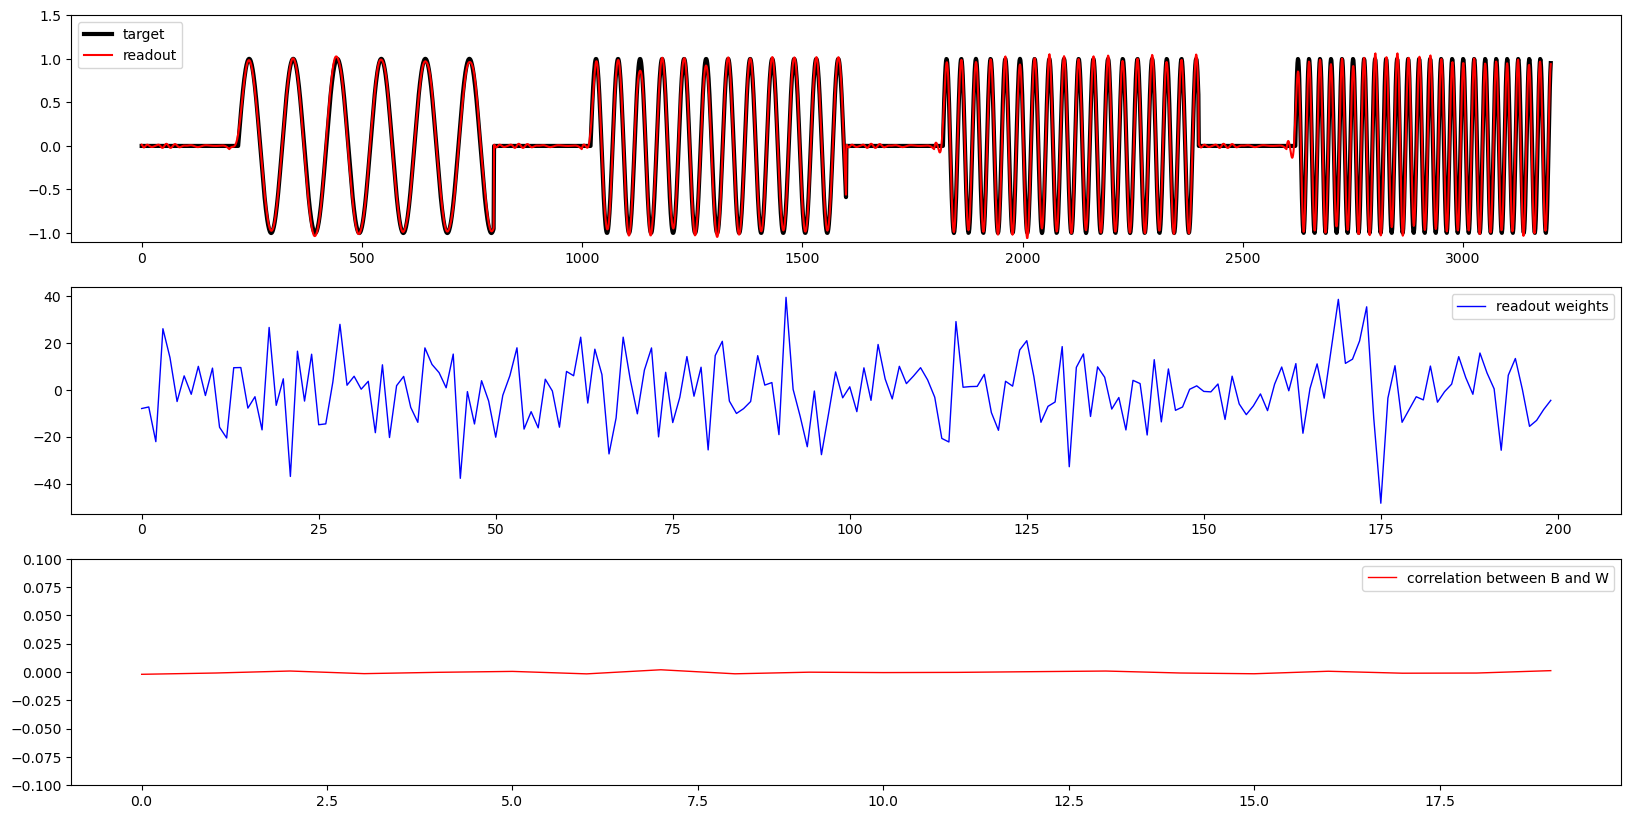

In [908]:
## use regression to define a B ##

# get rates from the trained FORCE network
rates,latents,_ = returnRates(U,inputs)

# reshape to be CT x N
rates_rs = rates.reshape(-1,numN,order='F');

# reshape the targets from our rate network
targets_rs = targets.reshape(-1,1,order='F')

# define a regularization term
ridgeLambda = 1e-4

# define the null space of W, project rates into this space
W_null = scipy.linalg.null_space(W.T)
rates_null = rates_rs@W_null

# regress
b_null = np.linalg.inv(rates_null.T @ rates_null + np.eye(rates_null.shape[1]) * ridgeLambda) @ rates_null.T @ targets_rs
B = W_null@b_null

# plot target and target_hat
yHat = rates_rs@B
plt.figure(figsize=(20,10))
plt.subplot(3,1,1);
plt.plot(targets_rs,'k',linewidth=3,label='target');
plt.plot(yHat,'r',label='readout');
plt.ylim([-1.1,1.5]);
plt.legend();

# plot B
plt.subplot(3,1,2);
plt.plot(B,'b',linewidth=1,label='readout weights');
plt.legend();

# calculate correlation between B and each column of W
plt.subplot(3,1,3);
bCorr = np.zeros(numZ) + np.nan
for ii in range(numZ):
    bCorr[ii] = np.corrcoef(B[:,0],W[:,ii])[0,1]
plt.plot(bCorr,'r',linewidth=1,label='correlation between B and W');
plt.ylim([-0.1,0.1]);
plt.legend();


### Learn two different perturbations to U: one that increases the amplitude of the output and one that decreases the amplitude
    - both will be drawn from B

In [909]:
# Perturb U with some fraction of B. Absorb changes that reduce error.

def runPertExperiment(out_o,target_2,IN,numTrials=100,alpha=1,pertMag=1e-7):

    # add an axis to our input
    IN = IN[:,np.newaxis]

    # initialize the U (keep it separate from our original U
    U_learn = np.copy(U)

    # generate our current error
    current_e = ((out_original - target2)**2).mean()

    # initialize an array to hold all of our outputs
    trlDur = target2.shape[0]
    output_learn = np.zeros((trlDur,numTrials)) + np.nan

    # keep track of our error
    bestError = np.zeros(numTrials)
    trialError = np.zeros(numTrials)

    # keep track of total perturbation
    totPert = np.zeros(numZ)

    # save all of our Us
    allUs = np.zeros((U_learn.shape[0],U_learn.shape[1],numTrials))

    # save all of the perturbations
    allPerts = np.zeros((numZ,numTrials))

    # cycle through trials
    for ii in range(numTrials):

        # save current U
        allUs[:,:,ii] = U_learn

        # generate a 'numZ' element vector that tells us how much of B to put into U_perturb
        pctB = np.random.normal(loc=0,scale=pertMag,size=(1,numZ))

        # generate our scaled B vectors
        bScaled = B @ pctB

        # generate our perturbed U
        U_pert = U_learn + bScaled.T

        # generate a perturbed output
        _,_,out = returnRates(U_pert,IN,B)

        # calculate new error
        newE = ((out[:,0] - target2)**2).mean()

        # update U_learn if things got better
        if newE < current_e:

            # calculate the percent change in error
            dE = (current_e - newE)/current_e

            # display the change in error
            print(str(dE*100) + ' percent change in error');

            # calculate step size
            step = alpha

            # take a step
            U_learn += (bScaled.T * step)

            # update our current error
            current_e = newE

        # save error
        bestError[ii] = current_e
        trialError[ii]  = newE

    # return error and our learned U
    return U_learn,bestError, trialError


In [910]:
# rather than choosing perturbations randomly, estimate the gradient by perturbing in a random direction, then taking a step down the gradient
# because we're taking small steps, we should be able to keep an running estimate of the gradient, rather than estimating it from a single perturbation

def runPertExperiment_estGrad(out_o,target_2,IN,numTrials=50,alpha=0.9,pertMag=1e-7):

    # add an axis to our input
    IN = IN[:,np.newaxis]

    # initialize the U (keep it separate from our original U
    U_learn = np.copy(U)

    # generate our current error
    current_e = ((out_original - target2)**2).mean()

    # initialize an array to hold all of our outputs
    trlDur = target2.shape[0]
    output_learn = np.zeros((trlDur,numTrials)) + np.nan

    # keep track of our error
    trialError = np.zeros(numTrials)

    # keep track of total perturbation
    totPert = np.zeros(numZ)

    # save all of our Us
    allUs = np.zeros((U_learn.shape[0],U_learn.shape[1],numTrials))

    # save all of the perturbations
    allPerts = np.zeros((numZ,numTrials))

    # save all of the gradients
    allGradEst = np.zeros((numZ,numTrials))

    # save all of the delta errors
    dE_all = np.zeros(numTrials)

    # cycle through trials
    for ii in range(numTrials):

        # save current U
        allUs[:,:,ii] = U_learn

        # generate a 'numZ' element vector that tells us how much of B to put into U_perturb
        pctB = np.random.normal(loc=0,scale=1,size=numZ)

        # normalize pctB to have a norm of 'pertMag'
        pctB_norm = (pctB/np.linalg.norm(pctB))* pertMag

        # make sure the vector is the right size
        pctB_norm = pctB_norm[np.newaxis,:]

        # generate our scaled B vectors
        bScaled = B @ pctB_norm

        # generate our perturbed U
        U_pert = U_learn + bScaled.T

        # generate a perturbed output
        _,_,out = returnRates(U_pert,IN,B)

        # calculate new error
        newE = ((out[:,0] - target2)**2).mean()

        # calculate change in error
        dE = newE - current_e

        # save change in error
        dE_all[ii] = dE

        # estimate the gradient
        gradEst = dE / pctB_norm

        # save estimate
        allGradEst[:,ii] = gradEst

        # normalize the gradient
        gradEst_norm = (gradEst / np.linalg.norm(gradEst,axis=1))*pertMag

        # take a step in that direction
        step = gradEst_norm * alpha

        # save the perturbation
        totPert += step[0,:]

        # generate the B perturbation
        bStep = B @ step

        # update U
        U_learn -= bStep.T

        # update and save error
        _,_,out = returnRates(U_learn,IN,B)

        # calculate new error
        current_e = ((out[:,0] - target2)**2).mean()
        trialError[ii]  = np.copy(current_e)

    # return error and our learned U
    return U_learn, trialError, allGradEst, totPert, dE_all

In [917]:

# define our new target
amp2 = 1.5
target2 = np.copy(targets[:,0]) * amp2

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)


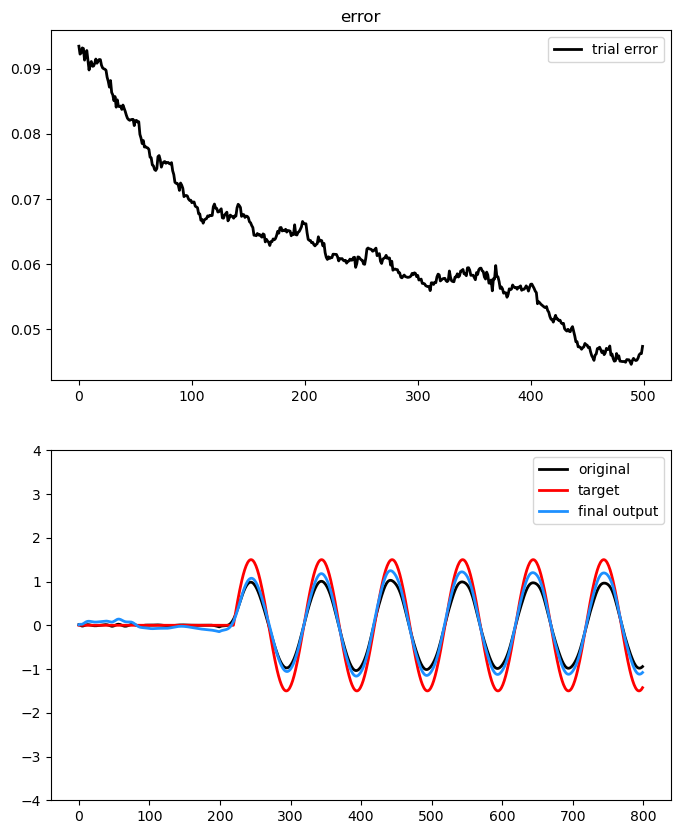

In [922]:
# test the gradient estimation method

# define our new target
amp2 = 1.5
target2 = np.copy(targets[:,0]) * amp2

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)

# run experiment
U_l_up_estGrad, trialError_up_estGrad, gradEst_estGrad,totPert,dE_all = runPertExperiment_estGrad(out_original,target2,IN,numTrials=500)


# plot results

# regenerate the output with the current U
_,_,out_final_estGrad = returnRates(U_l_up_estGrad,IN[:,np.newaxis],B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(trialError_up_estGrad,'k',linewidth=2,label='trial error');
plt.title('error')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(out_original,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final_estGrad[:,0],'dodgerblue',linewidth=2,label='final output')
plt.ylim([-4,4]);
plt.legend();


92.64126773857379 percent change in error
5.143921849169608 percent change in error
3.4409864459639707 percent change in error
2.5006732701192447 percent change in error
0.19493527235006033 percent change in error
3.189564054652821 percent change in error
5.040383982539567 percent change in error
0.5875984697575947 percent change in error
5.544475645447173 percent change in error
13.767904701885408 percent change in error
1.2131274238794403 percent change in error
2.709363509964942 percent change in error
0.21365459141807455 percent change in error
2.435974157761885 percent change in error
0.7863382068241649 percent change in error
0.5527826949764207 percent change in error
1.999400427479834 percent change in error
9.77360649719485 percent change in error
16.53955200677707 percent change in error
4.344313906347476 percent change in error
12.286385302027796 percent change in error
3.5993053112019147 percent change in error
1.244521544583462 percent change in error
8.781205502256244 perc

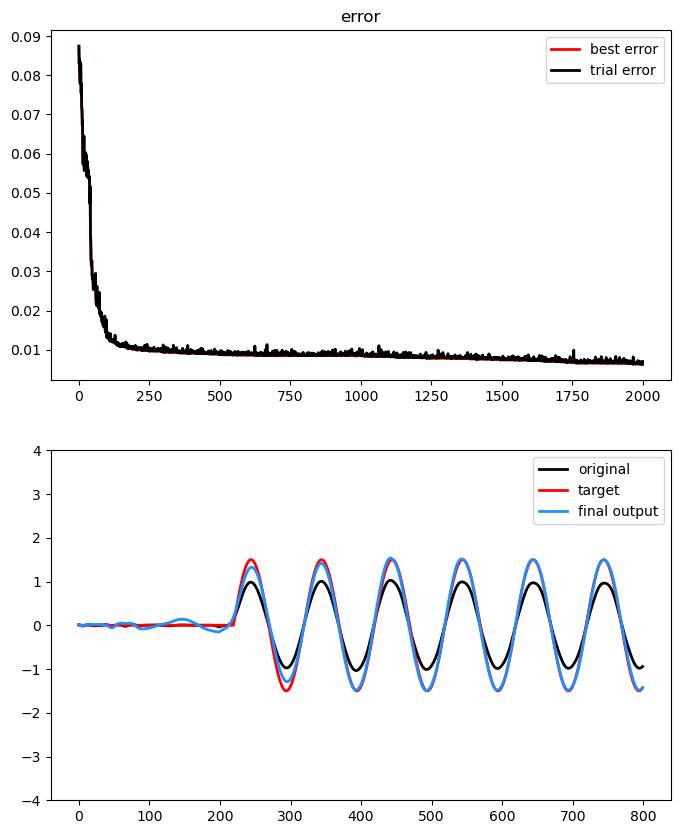

In [923]:
# find perturbation to increase amplitude of output

# define our new target
amp2 = 1.5
target2 = np.copy(targets[:,0]) * amp2

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)

# run experiment
U_l_up, bestError_up, trialError_up = runPertExperiment(out_original,target2,IN,alpha=1,numTrials=2000,pertMag=1e-7)

# plot results

# regenerate the output with the current U
_,_,out_final_up = returnRates(U_l_up,IN[:,np.newaxis],B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(bestError_up,'r',linewidth=2,label='best error')
plt.plot(trialError_up,'k',linewidth=2,label='trial error');
plt.title('error')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(out_original,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final_up,'dodgerblue',linewidth=2,label='final output')
plt.ylim([-4,4]);
plt.legend();


79.95757991367466 percent change in error
0.6536964056636366 percent change in error
2.240796486179495 percent change in error
2.0991478343026273 percent change in error
1.199835072882785 percent change in error
1.5962978868146898 percent change in error
3.5744194081908334 percent change in error
8.778799270324905 percent change in error
3.3787820748377806 percent change in error
2.3607141218319216 percent change in error
4.967118342935251 percent change in error
0.8278630109107199 percent change in error
2.8023574191787013 percent change in error
2.1161022241420966 percent change in error
3.888570549348928 percent change in error
3.6238343214956212 percent change in error
4.839627940646247 percent change in error
0.44420422787445946 percent change in error
3.22784928376709 percent change in error
1.22363018660484 percent change in error
6.153812923376998 percent change in error
1.016297725001982 percent change in error
3.3967401283800776 percent change in error
3.492355663374981 perce

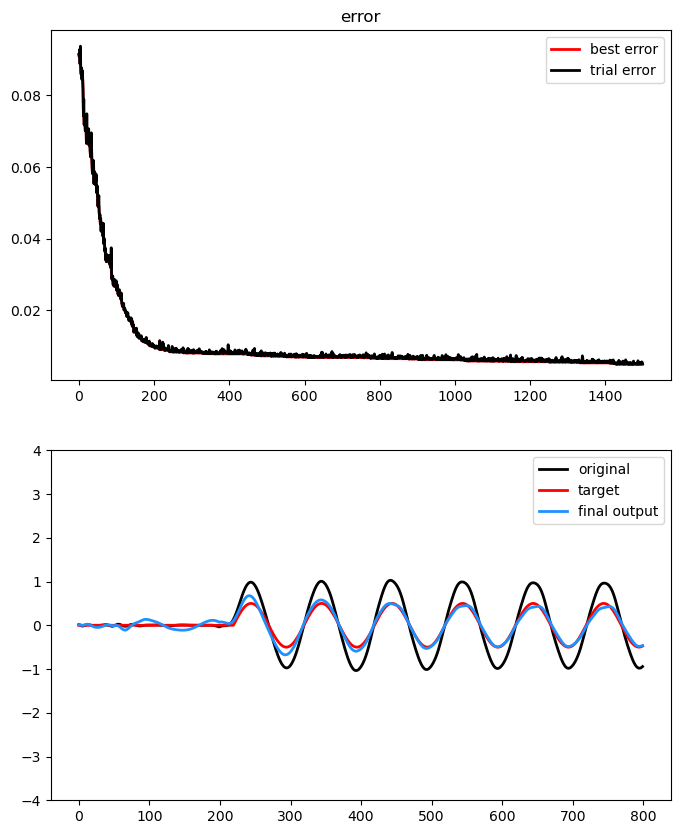

In [924]:
# find perturbation to decrease amplitude of output

# define our new target
amp2 = 0.5
target2 = np.copy(targets[:,0]) * amp2

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)

# run experiment
U_l_down, bestError_down, trialError_down = runPertExperiment(out_original,target2,IN,numTrials=1500,pertMag=1e-7)

# regenerate the output with the current U
_,_,out_final_down = returnRates(U_l_down,IN[:,np.newaxis],B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(bestError_down,'r',linewidth=2,label='best error')
plt.plot(trialError_down,'k',linewidth=2,label='trial error');
plt.title('error')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(out_original,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final_down,'dodgerblue',linewidth=2,label='final output')
plt.ylim([-4,4]);
plt.legend();


68.42141794945236 percent change in error
0.010903908856683565 percent change in error
2.78252055961071 percent change in error
1.2086156280664841 percent change in error
1.0271655831245676 percent change in error
0.0006711762795803454 percent change in error
0.8138264365091857 percent change in error
0.5770639143182561 percent change in error
1.9419310796142761 percent change in error
0.5690569220672526 percent change in error
0.16206049686081492 percent change in error
0.00627512707982105 percent change in error
1.130036225196181 percent change in error
0.6358013124371135 percent change in error
0.9999557280157249 percent change in error
0.19786852533613788 percent change in error
2.2089278737135816 percent change in error
0.2920900026242404 percent change in error
0.8896790716496983 percent change in error
1.240754229775015 percent change in error
2.5240766542487663 percent change in error
1.3614221263050938 percent change in error
2.960255621513228 percent change in error
0.1932172

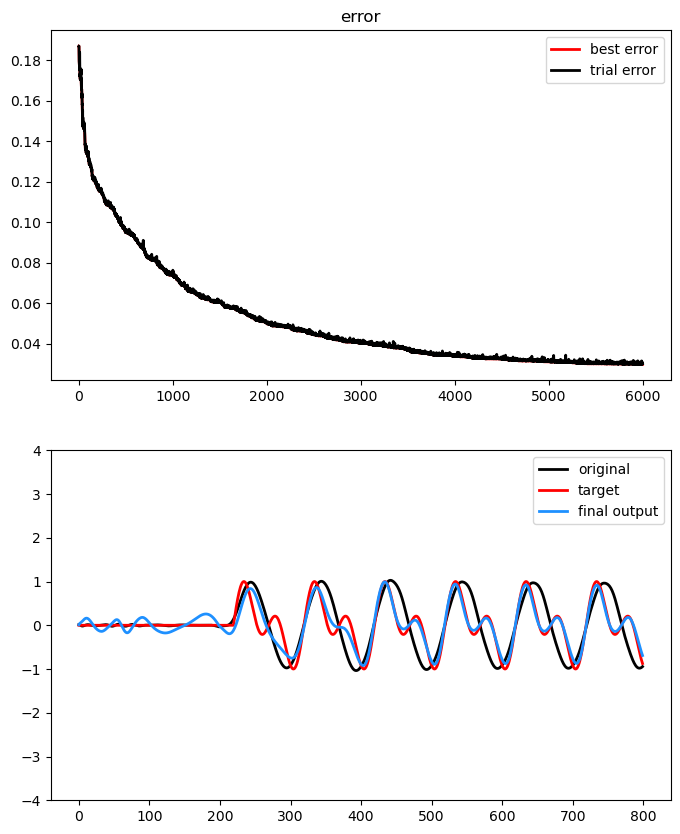

In [927]:
# see if I can get something a little wonkier

target2 = np.copy(1*targets[:,0] + 1*targets[:,1])

# normalize to a max of 1
target2 = target2 / np.max(target2)

# pull out input
IN = inputs[:,0]

#pull our original target
_,_,out_original = returnRates(U,IN[:,np.newaxis],B)

# run experiment
U_l_wonky, bestError_wonky, trialError_wonky = runPertExperiment(out_original,target2,IN,numTrials=6000,pertMag=1e-7)

# regenerate the output with the current U
_,_,out_final_wonky = returnRates(U_l_wonky,IN[:,np.newaxis],B)

# plot error
plt.figure(figsize=(8,10))
plt.subplot(2,1,1);
plt.plot(bestError_wonky,'r',linewidth=2,label='best error')
plt.plot(trialError_wonky,'k',linewidth=2,label='trial error');
plt.title('error')
plt.legend()

# plot output
plt.subplot(2,1,2)

# plot original
plt.plot(out_original,'k',linewidth=2,label='original')

# plot target
plt.plot(target2,'r',linewidth=2,label='target')

# plot final output
plt.plot(out_final_wonky,'dodgerblue',linewidth=2,label='final output')
plt.ylim([-4,4]);
plt.legend();

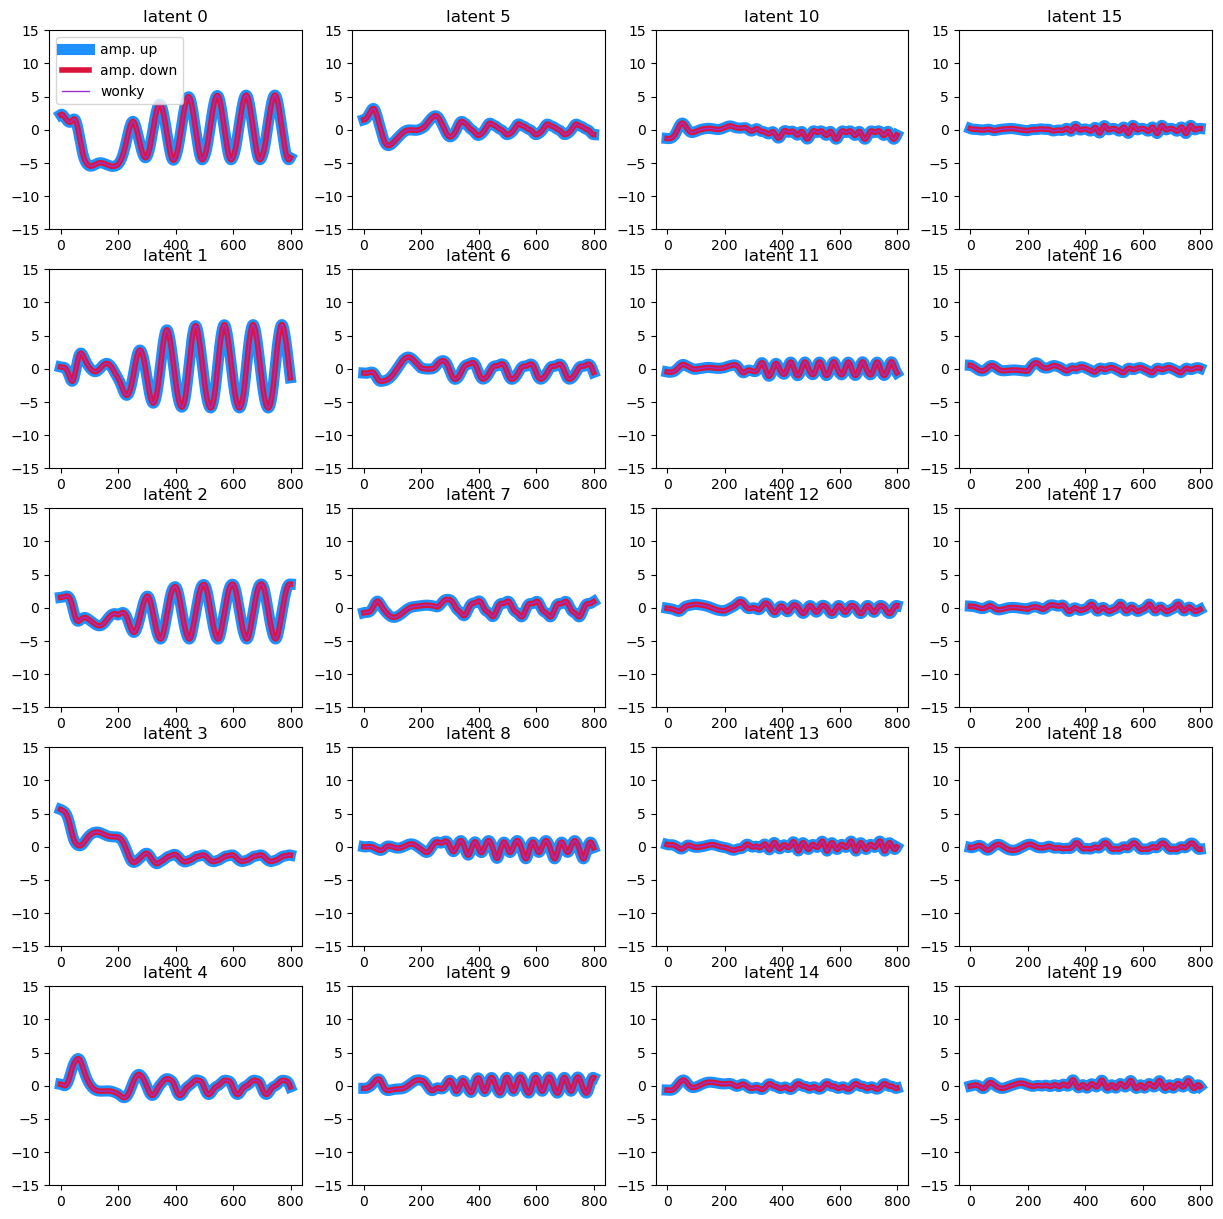

In [928]:
# generate latents for each of these learned U perturbations

# put everything in a list to make life easy
U_perts = [U_l_up, U_l_down, U_l_wonky]

# initialize a list to hold latents
perturbedLatents = []

# cycle through perturbations
for ii in range(3):

    # grab our input
    IN = inputs[:,1]

    # regenerate the output
    _,tempLats,_ = returnRates(U_perts[ii],IN[:,np.newaxis],B)

    # add to list
    perturbedLatents.append(tempLats)

# cycle through all of the latents and plot

# plot the first and last trial (along with the target)
fig, ax = plt.subplots(5,4, figsize = (15,15))

# define some colors
colors = ['dodgerblue','crimson','darkorchid']
labels = ['amp. up','amp. down','wonky']
lineWidths = [8,4,1]

for ii in range(numZ):

    # get the row and column index
    rIdx = np.mod(ii,5)
    cIdx = (ii//5)

    # cycle through latents
    for jj in range(3):

        # plot
        ax[rIdx,cIdx].plot(perturbedLatents[jj][:,0,ii],color = colors[jj],linewidth=lineWidths[jj],label=labels[jj]);

    # change the y scale
    ax[rIdx,cIdx].set_ylim([-15,15]);

    # add a title
    ax[rIdx,cIdx].set_title('latent ' + str(ii))

    if ii==0:
        ax[rIdx,cIdx].legend()

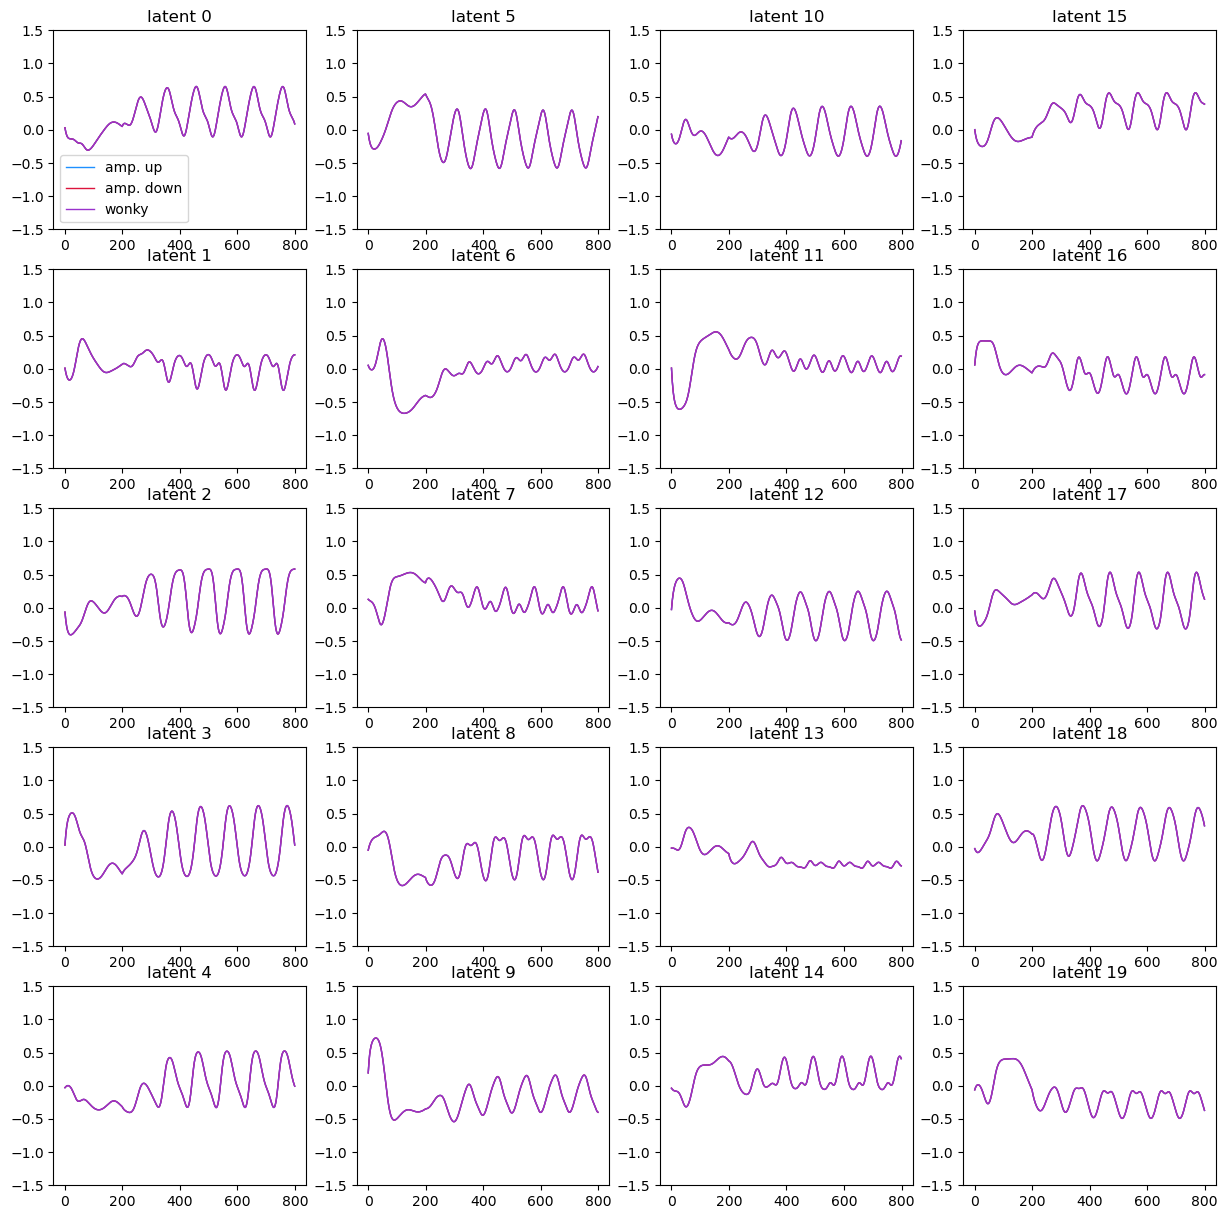

In [932]:
# plot a few example units

# put everything in a list to make life easy
U_perts = [U_l_up, U_l_down, U_l_wonky]

# initialize a list to hold latents
perturbedRates = []
perturbedOutput = []

# cycle through perturbations
for ii in range(3):

    # grab our input
    IN = inputs[:,1]

    # regenerate the output
    tempRates,_,output = returnRates(U_perts[ii],IN[:,np.newaxis],B)

    # add to list
    perturbedRates.append(tempRates)
    perturbedOutput.append(output)

#cycle through the first 10 units and plot

# plot the first and last trial (along with the target)
fig, ax = plt.subplots(5,4, figsize = (15,15))

# choose 10 random neurons to plot
randIdx = np.random.choice(numN,size=numZ,replace=False)

# define some colors
colors = ['dodgerblue','crimson','darkorchid']
labels = ['amp. up','amp. down','wonky']
lineWidths = [1,1,1]

for ii in range(numZ):

    # get the row and column index
    rIdx = np.mod(ii,5)
    cIdx = (ii//5)

    # cycle through latents
    for jj in range(3):

        # plot
        ax[rIdx,cIdx].plot(perturbedRates[jj][:,0,randIdx[ii]],color = colors[jj],linewidth=lineWidths[jj],label=labels[jj]);

    # change the y scale
    ax[rIdx,cIdx].set_ylim([-1.5,1.5]);

    # add a title
    ax[rIdx,cIdx].set_title('latent ' + str(ii))

    if ii==0:
        ax[rIdx,cIdx].legend()